In [36]:
import os
import pandas as pd
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# ============================================
# 0. Configuración básica
# ============================================
REPO_URL = "https://github.com/fmplaza/EmoEvent.git"
REPO_DIR = "EmoEvent"
LANG = "es"  # 'es' para español, 'en' para inglés

SPLITS_DIR = os.path.join(REPO_DIR, "splits", LANG)
TRAIN_PATH = os.path.join(SPLITS_DIR, "train.tsv")
DEV_PATH   = os.path.join(SPLITS_DIR, "dev.tsv")
TEST_PATH  = os.path.join(SPLITS_DIR, "test.tsv")

MODEL_CHECKPOINT = "dccuchile/bert-base-spanish-wwm-cased"

# ============================================
# 1. Clonar repo (si hace falta)
# ============================================
if not os.path.isdir(REPO_DIR):
    print(f"Clonando repositorio {REPO_URL}...")
    !git clone {REPO_URL}
else:
    print(f"Repositorio '{REPO_DIR}' ya existe, se omite clonación.")

# ============================================
# 2. Función auxiliar de carga
# ============================================
def load_tsv(path: str) -> pd.DataFrame:
    """Carga un archivo .tsv y avisa qué está cargando."""
    if not os.path.exists(path):
        raise FileNotFoundError(f"No se encontró el archivo: {path}")
    print(f"Cargando: {path}")
    return pd.read_csv(path, sep="\t")

# ============================================
# 3. Cargar splits en DataFrames
# ============================================
df_train = load_tsv(TRAIN_PATH)
df_dev   = load_tsv(DEV_PATH)
df_test  = load_tsv(TEST_PATH)

# ============================================
# 4. Crear DatasetDict de Hugging Face
# ============================================
dataset = DatasetDict(
    {
        "train": Dataset.from_pandas(df_train, preserve_index=False),
        "validation": Dataset.from_pandas(df_dev, preserve_index=False),
        "test": Dataset.from_pandas(df_test, preserve_index=False),
    }
)

print("\n✅ Dataset cargado correctamente:")
print(dataset)
print("\nEjemplo de train:")
print(dataset["train"][0])

# ============================================
# 5. Limpieza básica de textos
#    (quitamos ejemplos sin tweet o vacío)
# ============================================
print("\n--- Limpieza de textos ---")
print(f"Tamaño original test: {len(dataset['test'])}")

dataset = dataset.filter(
    lambda example: isinstance(example["tweet"], str) and len(example["tweet"]) > 0
)

print(f"Tamaño test después de limpiar: {len(dataset['test'])}")

# ============================================
# 6. Preparar etiquetas (label encoding)
# ============================================
print("\nProcesando etiquetas...")

label_list = sorted(set(dataset["train"]["emotion"]))
label2id = {label: i for i, label in enumerate(label_list)}
id2label = {i: label for i, label in enumerate(label_list)}

print(f"Etiquetas detectadas (label2id): {label2id}")

def encode_labels(example):
    """Añade columna 'label' numérica a partir de 'emotion'."""
    return {"label": label2id[example["emotion"]]}

dataset = dataset.map(encode_labels)

print("\n✅ Columna 'label' numérica añadida.")
print("Ejemplo actualizado de train:")
print(dataset["train"][0])

# ============================================
# 7. Tokenizador (BETO) + función de tokenización
# ============================================
tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)

def tokenize_function(examples):
    return tokenizer(
        examples["tweet"],
        padding="max_length",
        truncation=True,
        max_length=128,
    )

print("\nTokenizando el dataset...")
encoded_dataset = dataset.map(tokenize_function, batched=True)

print("✅ Tokenización completada.")
print("Keys de un ejemplo de train:")
print(encoded_dataset["train"][0].keys())

# ============================================
# 8. Cargar modelo BETO para clasificación
# ============================================
num_labels = len(label_list)

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_CHECKPOINT,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
)

print("\n✅ Modelo BETO cargado.")
print("Número de etiquetas:", num_labels)


Repositorio 'EmoEvent' ya existe, se omite clonación.
Cargando: EmoEvent/splits/es/train.tsv
Cargando: EmoEvent/splits/es/dev.tsv
Cargando: EmoEvent/splits/es/test.tsv

✅ Dataset cargado correctamente:
DatasetDict({
    train: Dataset({
        features: ['id', 'event', 'tweet', 'offensive', 'emotion'],
        num_rows: 5723
    })
    validation: Dataset({
        features: ['id', 'event', 'tweet', 'offensive', 'emotion'],
        num_rows: 844
    })
    test: Dataset({
        features: ['id', 'event', 'tweet', 'offensive', 'emotion'],
        num_rows: 1656
    })
})

Ejemplo de train:
{'id': 'a0c1a858-a9b8-4cb1-8a81-1602736ff5b8', 'event': 'GameOfThrones', 'tweet': 'La Gran Guerra de #JuegoDeTronos nos ha dejado muchos momentos para el recuerdo y unas cuantas dudas https://t.co/UE7lCgLSez https://t.co/OO3tjUR34c', 'offensive': 'NO', 'emotion': 'others'}

--- Limpieza de textos ---
Tamaño original test: 1656


Filter:   0%|          | 0/5723 [00:00<?, ? examples/s]

Filter:   0%|          | 0/844 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1656 [00:00<?, ? examples/s]

Tamaño test después de limpiar: 1626

Procesando etiquetas...
Etiquetas detectadas (label2id): {'anger': 0, 'disgust': 1, 'fear': 2, 'joy': 3, 'others': 4, 'sadness': 5, 'surprise': 6}


Map:   0%|          | 0/5723 [00:00<?, ? examples/s]

Map:   0%|          | 0/844 [00:00<?, ? examples/s]

Map:   0%|          | 0/1626 [00:00<?, ? examples/s]


✅ Columna 'label' numérica añadida.
Ejemplo actualizado de train:
{'id': 'a0c1a858-a9b8-4cb1-8a81-1602736ff5b8', 'event': 'GameOfThrones', 'tweet': 'La Gran Guerra de #JuegoDeTronos nos ha dejado muchos momentos para el recuerdo y unas cuantas dudas https://t.co/UE7lCgLSez https://t.co/OO3tjUR34c', 'offensive': 'NO', 'emotion': 'others', 'label': 4}

Tokenizando el dataset...


Map:   0%|          | 0/5723 [00:00<?, ? examples/s]

Map:   0%|          | 0/844 [00:00<?, ? examples/s]

Map:   0%|          | 0/1626 [00:00<?, ? examples/s]

✅ Tokenización completada.
Keys de un ejemplo de train:
dict_keys(['id', 'event', 'tweet', 'offensive', 'emotion', 'label', 'input_ids', 'token_type_ids', 'attention_mask'])


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



✅ Modelo BETO cargado.
Número de etiquetas: 7


In [37]:
!pip install --upgrade transformers


In [38]:
import transformers
print(transformers.__version__)


4.57.3


In [8]:
# ============================================
# 9. Entrenamiento con Trainer (bloque actualizado)
# ============================================
import os
import numpy as np
import json
from transformers import TrainingArguments, Trainer, set_seed
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

os.environ["WANDB_DISABLED"] = "true"
set_seed(42)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, predictions),
        "f1": f1_score(labels, predictions, average="weighted"),
        "precision": precision_score(labels, predictions, average="weighted"),
        "recall": recall_score(labels, predictions, average="weighted"),
    }

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",          # <- Cambiado
    save_strategy="epoch",
    save_total_limit=2,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none",
    logging_steps=50,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    compute_metrics=compute_metrics,
)

print("Iniciando entrenamiento...")
train_result = trainer.train()

trainer.save_model()
os.makedirs("./results", exist_ok=True)
with open("./results/train_metrics.json", "w") as f:
    json.dump(train_result.metrics, f, indent=4)

print("\nEvaluando en Test Set...")
test_results = trainer.evaluate(encoded_dataset["test"])
with open("./results/test_metrics.json", "w") as f:
    json.dump(test_results, f, indent=4)

print(f"\n✅ Test accuracy: {test_results['eval_accuracy']:.4f}")
print(f"✅ Test F1 (weighted): {test_results['eval_f1']:.4f}")
print(f"✅ Precision: {test_results.get('eval_precision',0):.4f}")
print(f"✅ Recall: {test_results.get('eval_recall',0):.4f}")


Iniciando entrenamiento...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.900100,0.843042,0.691943,0.675869,0.667232,0.691943
2,0.684800,0.800389,0.719194,0.702073,0.694642,0.719194
3,0.421800,0.865006,0.719194,0.705590,0.698025,0.719194


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Evaluando en Test Set...



✅ Test accuracy: 0.3530
✅ Test F1 (weighted): 0.3445
✅ Precision: 0.3368
✅ Recall: 0.3530


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Aquí encontramos algunas cosas interesantes, se indica que alguans clases del conjunto de evaluacion no estan siendo predichas por el modelo. por eso precision_score no puede calcularse correctamente para esas clases. Ahora podemos pensar en un por qué ocurre eso.

1. El modelo puede estar desbalanceado 
2. Algunas clases tienen pocos ejemplos en el dataset
3. El modelo no aprende a predecir ciertas clases. 

Ahora procederemos a analizar la matriz de confusion, evaluar el balance de clases en el dataset. 

In [9]:
import numpy as np
np.unique(encoded_dataset["train"]['label'], return_counts=True)


(array([0, 1, 2, 3, 4, 5, 6]),
 array([ 589,  111,   65, 1227, 2800,  693,  238]))

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


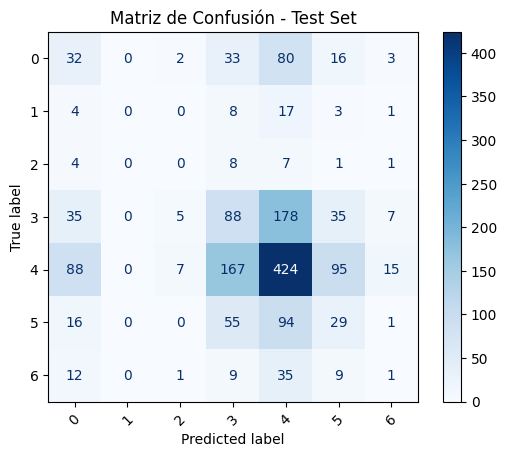

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Obtener predicciones sobre test set
predictions = trainer.predict(encoded_dataset["test"])
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=-1)

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(xticks_rotation=45, cmap="Blues")
plt.title("Matriz de Confusión - Test Set")
plt.grid(False)
plt.show()


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


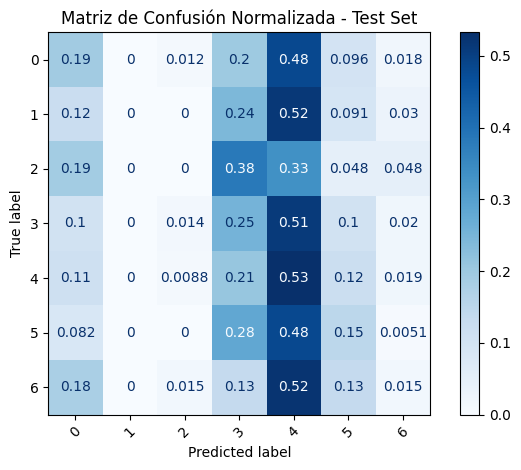

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Obtener predicciones
predictions = trainer.predict(encoded_dataset["test"])
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=-1)

# Matriz normalizada por fila (porcentaje)
cm_norm = confusion_matrix(y_true, y_pred, normalize='true')

# Visualizar
disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm)
disp.plot(xticks_rotation=45, cmap="Blues", colorbar=True)

plt.title("Matriz de Confusión Normalizada - Test Set")
plt.grid(False)
plt.tight_layout()
plt.show()


In [12]:
from transformers import pipeline

# 1. Pipeline
classifier = pipeline("text-classification", model=model, tokenizer=tokenizer, device=0)

def probar_frase(texto):
    prediction = classifier(texto)[0]
    
    etiqueta = prediction['label'] 
    score = prediction['score']
    
    # Traducimos al español visualmente para que quede más bonito
    return f"🗣️: '{texto}' \n   --> : {etiqueta.upper()} ({score:.1%})\n"

print("--- RESULTADOS EN VIVO (AHORA SÍ) ---")
print(probar_frase("¡Estoy harto de que siempre llegues tarde!"))      
print(probar_frase("Qué felicidad, por fin terminamos el proyecto."))    
print(probar_frase("Tengo miedo de caminar solo por esa calle."))        
print(probar_frase("Me da asco la comida que sirvieron hoy."))           
print(probar_frase("Es una pena que no hayas podido venir."))

Device set to use cuda:0


--- RESULTADOS EN VIVO (AHORA SÍ) ---
🗣️: '¡Estoy harto de que siempre llegues tarde!' 
   --> : ANGER (54.7%)

🗣️: 'Qué felicidad, por fin terminamos el proyecto.' 
   --> : JOY (97.5%)

🗣️: 'Tengo miedo de caminar solo por esa calle.' 
   --> : FEAR (73.6%)

🗣️: 'Me da asco la comida que sirvieron hoy.' 
   --> : ANGER (58.6%)

🗣️: 'Es una pena que no hayas podido venir.' 
   --> : SADNESS (97.5%)



In [14]:
pip install nlpaug nltk


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 12.3 MB/s eta 0:00:00


In [15]:
import nltk
nltk.download("wordnet")
nltk.download("omw-1.4")


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [17]:
print(encoded_dataset["train"].column_names)


['id', 'event', 'tweet', 'offensive', 'emotion', 'label', 'input_ids', 'token_type_ids', 'attention_mask']


In [23]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')  # este es el correcto


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [26]:
import os
from nltk.data import find

# Ruta original del tagger que sí existe
original = find('taggers/averaged_perceptron_tagger')

# Ruta que espera nlpaug (errónea, pero necesaria para evitar el error)
symlink_path = os.path.join(original[:-len('averaged_perceptron_tagger')], 'averaged_perceptron_tagger_eng')

# Crear el enlace simbólico si no existe
if not os.path.exists(symlink_path):
    os.symlink(original, symlink_path)
    print("✅ Enlace simbólico creado para evitar el error de nlpaug.")
else:
    print("✅ El enlace simbólico ya existe.")


✅ Enlace simbólico creado para evitar el error de nlpaug.


In [39]:
from datasets import Dataset, concatenate_datasets
from collections import Counter
import nlpaug.augmenter.word as naw

# Dataset original
train_dataset = encoded_dataset["train"]

# Augmentador simple (no depende de wordnet/taggers)
aug = naw.RandomWordAug(action="swap")  # o "insert", "delete"

# Umbral mínimo
THRESHOLD = 500

# Recuento actual
label_counts = Counter(train_dataset["label"])
print("📊 Recuento antes de balancear:")
for l, c in sorted(label_counts.items()):
    print(f"Clase {l}: {c} ejemplos")

# Guardar todo aquí
augmented_datasets = []

# Procesar todas las clases
for label, count in label_counts.items():
    class_subset = train_dataset.filter(lambda x: x["label"] == label)
    augmented_datasets.append(class_subset)  # conservar originales
    
    if count < THRESHOLD:
        needed = THRESHOLD - count
        print(f"\n🔁 Clase {label}: generando {needed} ejemplos adicionales")
        selected = class_subset.shuffle(seed=42).select(range(min(needed, len(class_subset))))
        
        new_texts = []
        new_labels = []
        for i in range(needed):
            original = selected[i % len(selected)]
            try:
                augmented_text = aug.augment(original["tweet"])
                # asegurarse que sea string plano
                new_texts.append(augmented_text if isinstance(augmented_text, str) else augmented_text[0])
                new_labels.append(label)
            except Exception as e:
                print(f"⚠️ Error: {original['tweet']} → {e}")
                continue
        
        new_dataset = Dataset.from_dict({"tweet": new_texts, "label": new_labels})
        augmented_datasets.append(new_dataset)

# Combinar todo y mezclar
balanced_dataset = concatenate_datasets(augmented_datasets).shuffle(seed=42)
encoded_dataset["train"] = balanced_dataset

# Mostrar distribución final
final_counts = Counter(encoded_dataset["train"]["label"])
print("\n✅ Dataset final balanceado:")
for label, count in sorted(final_counts.items()):
    print(f"Clase {label}: {count} ejemplos")


📊 Recuento antes de balancear:
Clase 0: 589 ejemplos
Clase 1: 111 ejemplos
Clase 2: 65 ejemplos
Clase 3: 1227 ejemplos
Clase 4: 2800 ejemplos
Clase 5: 693 ejemplos
Clase 6: 238 ejemplos


Filter:   0%|          | 0/5723 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5723 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5723 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5723 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5723 [00:00<?, ? examples/s]


🔁 Clase 6: generando 262 ejemplos adicionales


Filter:   0%|          | 0/5723 [00:00<?, ? examples/s]


🔁 Clase 1: generando 389 ejemplos adicionales


Filter:   0%|          | 0/5723 [00:00<?, ? examples/s]


🔁 Clase 2: generando 435 ejemplos adicionales

✅ Dataset final balanceado:
Clase 0: 589 ejemplos
Clase 1: 500 ejemplos
Clase 2: 500 ejemplos
Clase 3: 1227 ejemplos
Clase 4: 2800 ejemplos
Clase 5: 693 ejemplos
Clase 6: 500 ejemplos


In [40]:
def tokenize_function(example):
    return tokenizer(
        example["tweet"],
        padding="max_length",
        truncation=True,
        max_length=128,
    )

# Volver a tokenizar solo el set de entrenamiento balanceado
encoded_dataset["train"] = encoded_dataset["train"].map(tokenize_function, batched=True)

print("✅ Re-tokenización completada.")


Map:   0%|          | 0/6809 [00:00<?, ? examples/s]

✅ Re-tokenización completada.


In [ ]:
from transformers import TrainingArguments, Trainer
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import os

# Desactivar WandB si estás en Colab o entorno sin login
os.environ["WANDB_DISABLED"] = "true"

# Métricas personalizadas
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, predictions),
        "f1": f1_score(labels, predictions, average="weighted"),
        "precision": precision_score(labels, predictions, average="weighted", zero_division=0),
        "recall": recall_score(labels, predictions, average="weighted")
    }

# Argumentos de entrenamiento
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",       
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none",
    logging_steps=50,
)


# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    compute_metrics=compute_metrics,
)

# Entrenar
print("Iniciando entrenamiento...")
train_result = trainer.train()

# Evaluar en test
print("\nEvaluando en Test Set...")
test_results = trainer.evaluate(encoded_dataset["test"])
print(test_results)

# Métricas bonitas
print(f"\n✅ Test accuracy: {test_results['eval_accuracy']:.4f}")
print(f"✅ Test F1 (weighted): {test_results['eval_f1']:.4f}")
print(f"✅ Precision: {test_results['eval_precision']:.4f}")
print(f"✅ Recall: {test_results['eval_recall']:.4f}")


Iniciando entrenamiento...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.803700,0.819742,0.706161,0.695824,0.688678,0.706161
2,0.562900,0.850359,0.703791,0.692422,0.692240,0.703791
3,0.339900,0.907642,0.714455,0.706326,0.700180,0.714455



Evaluando en Test Set...


{'eval_loss': 2.8776047229766846, 'eval_accuracy': 0.35301353013530135, 'eval_f1': 0.34476618570295126, 'eval_precision': 0.3377621971381142, 'eval_recall': 0.35301353013530135, 'eval_runtime': 12.1554, 'eval_samples_per_second': 133.768, 'eval_steps_per_second': 8.391, 'epoch': 3.0}

✅ Test accuracy: 0.3530
✅ Test F1 (weighted): 0.3448
✅ Precision: 0.3378
✅ Recall: 0.3530


Generando predicciones para la Matriz de Confusión...


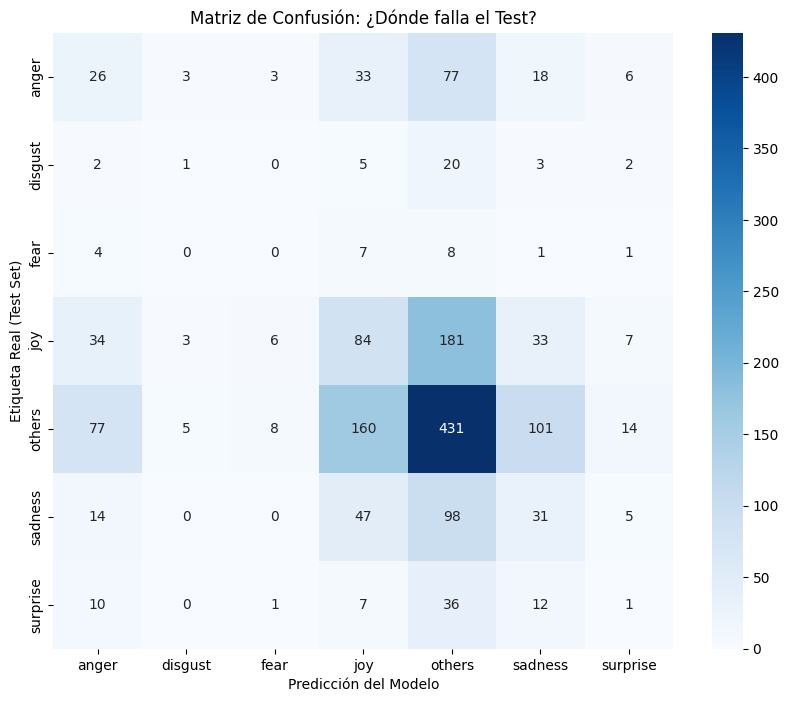

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# 1. Obtener predicciones masivas sobre el Test Set
print("Generando predicciones para la Matriz de Confusión...")
predictions_output = trainer.predict(encoded_dataset["test"])
preds = np.argmax(predictions_output.predictions, axis=-1)
true_labels = predictions_output.label_ids

# 2. Crear la Matriz
cm = confusion_matrix(true_labels, preds)
# Normalizamos para ver porcentajes (opcional, pero ayuda a ver mejor los errores)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# 3. Graficar
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[id2label[i] for i in range(len(id2label))],
            yticklabels=[id2label[i] for i in range(len(id2label))])
plt.ylabel('Etiqueta Real (Test Set)')
plt.xlabel('Predicción del Modelo')
plt.title('Matriz de Confusión: ¿Dónde falla el Test?')
plt.show()

In [45]:
from transformers import pipeline

# 1. Pipeline
classifier = pipeline("text-classification", model=model, tokenizer=tokenizer, device=0)

def probar_frase(texto):
    prediction = classifier(texto)[0]
    
    etiqueta = prediction['label'] 
    score = prediction['score']
    
    # Traducimos al español visualmente para que quede más bonito
    return f"🗣️: '{texto}' \n   --> : {etiqueta.upper()} ({score:.1%})\n"

print("--- RESULTADOS EN VIVO (AHORA SÍ) ---")
print(probar_frase("¡Estoy harto de que siempre llegues tarde!"))      
print(probar_frase("Qué felicidad, por fin terminamos el proyecto."))    
print(probar_frase("Tengo miedo de caminar solo por esa calle."))        
print(probar_frase("Me da asco la comida que sirvieron hoy."))           
print(probar_frase("Es una pena que no hayas podido venir."))

Device set to use cuda:0


--- RESULTADOS EN VIVO (AHORA SÍ) ---
🗣️: '¡Estoy harto de que siempre llegues tarde!' 
   --> : ANGER (73.8%)

🗣️: 'Qué felicidad, por fin terminamos el proyecto.' 
   --> : JOY (97.8%)

🗣️: 'Tengo miedo de caminar solo por esa calle.' 
   --> : FEAR (89.9%)

🗣️: 'Me da asco la comida que sirvieron hoy.' 
   --> : ANGER (65.3%)

🗣️: 'Es una pena que no hayas podido venir.' 
   --> : SADNESS (97.5%)



In [47]:
# Mantenemos tu función original
def probar_frase(texto):
    prediction = classifier(texto)[0]
    etiqueta = prediction['label'] 
    score = prediction['score']
    # Usamos iconos para visualizar rápido
    return f"🗣️: '{texto}' \n   --> 🤖: {etiqueta.upper()} ({score:.1%})\n"

print("--- 1. PRUEBAS FÁCILES (Calentamiento) ---")
print(probar_frase("¡Eres un estúpido, no quiero volverte a ver!")) # Anger
print(probar_frase("Me han dado el puesto de trabajo que soñaba.")) # Joy
print(probar_frase("Mi perro se murió ayer y no paro de llorar."))  # Sadness
print(probar_frase("¡Hay una araña gigante en mi cama, ayuda!"))    # Fear

print("--- 2. PRUEBAS IMPLÍCITAS (Sin palabras clave) ---")
# Aquí no decimos "triste" ni "feliz", el modelo debe entender el contexto
print(probar_frase("Siento un vacío en el pecho que no se me quita con nada.")) # Debería ser Sadness
print(probar_frase("No me esperaba para nada que me hicieran esa fiesta."))      # Debería ser Surprise o Joy
print(probar_frase("Escuché un ruido en el sótano y estoy solo en casa..."))    # Debería ser Fear
print(probar_frase("La comida tenía un pelo y olía a podrido."))                 # Debería ser Disgust o Anger

print("--- 3. JERGA Y EXPRESIONES (El reto real para BETO) ---")
print(probar_frase("¡Qué pasada! No me lo puedo creer."))             # Joy o Surprise
print(probar_frase("Estoy hasta las narices de tus excusas."))        # Anger
print(probar_frase("Me dio un vuelco el corazón cuando frenó el coche.")) # Fear o Surprise
print(probar_frase("Qué asco de gente, son repulsivos."))             # Disgust

print("--- 4. ZONA DE CONFUSIÓN (Anger vs Disgust vs Sadness) ---")
# Estas suelen confundir a las IAs
print(probar_frase("No puedo creer que me hayas traicionado así."))   # Anger o Sadness
print(probar_frase("Me enferma ver cómo tratan a los animales."))     # Disgust o Anger
print(probar_frase("Simplemente ya no tengo fuerzas para seguir."))   # Sadness
print(probar_frase("¿Es en serio? ¿Otra vez lo mismo?"))              # Anger (Frustración)

print("--- 5. PRUEBA DE FUEGO: SARCASMO E IRONÍA ---")
# Esto es lo más difícil para una IA. Si acierta esto, es un genio.
print(probar_frase("Genial, justo lo que necesitaba, que se me pinche la rueda hoy.")) # Anger (aunque diga 'Genial')
print(probar_frase("Me encanta esperar dos horas en la fila, es mi pasatiempo favorito.")) # Anger

--- 1. PRUEBAS FÁCILES (Calentamiento) ---
🗣️: '¡Eres un estúpido, no quiero volverte a ver!' 
   --> 🤖: ANGER (79.5%)

🗣️: 'Me han dado el puesto de trabajo que soñaba.' 
   --> 🤖: JOY (94.7%)

🗣️: 'Mi perro se murió ayer y no paro de llorar.' 
   --> 🤖: SADNESS (97.9%)

🗣️: '¡Hay una araña gigante en mi cama, ayuda!' 
   --> 🤖: OTHERS (56.8%)

--- 2. PRUEBAS IMPLÍCITAS (Sin palabras clave) ---
🗣️: 'Siento un vacío en el pecho que no se me quita con nada.' 
   --> 🤖: SADNESS (89.3%)

🗣️: 'No me esperaba para nada que me hicieran esa fiesta.' 
   --> 🤖: SURPRISE (44.6%)

🗣️: 'Escuché un ruido en el sótano y estoy solo en casa...' 
   --> 🤖: OTHERS (79.6%)

🗣️: 'La comida tenía un pelo y olía a podrido.' 
   --> 🤖: OTHERS (44.7%)

--- 3. JERGA Y EXPRESIONES (El reto real para BETO) ---
🗣️: '¡Qué pasada! No me lo puedo creer.' 
   --> 🤖: JOY (60.6%)

🗣️: 'Estoy hasta las narices de tus excusas.' 
   --> 🤖: ANGER (88.6%)

🗣️: 'Me dio un vuelco el corazón cuando frenó el coche.' 
   --> 🤖: